# NoteBook For Final Temperature Fitting
Created by Wenhan Hua on Aug 6th, 2023

## Context

### Noise Model
Generated the noise by *scipy.random.normal*, test its specturm and PSD(power spectrum density)

### A single particle driven by Noise + Damping Force

Temperature Fitting method
1. Average kinetic energy
2. Boltzman distribution(only kinetic energy)
3. Boltzman distribution(both kinetic energy and potential energy)

### A spring driven by Noise

Temperature Fitting method
1. Average kinetic energy
2. Boltzman distribution(only kinetic energy)
3. Boltzman distribution(both kinetic energy and potential energy)

In [2]:
import numpy as np
from scipy.fft import fft, fftfreq, ifft
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.signal import find_peaks
from scipy.optimize import leastsq

# Particle initial condition definition

In [80]:
# spring constant
m = 0.01
k = 1e-1
beta = 1e0

# initial situation
x0 = 1e-6
v0 = 0.
Vec0 = x0, v0


# simulation parameters
TotalTime = 1e-6
dt = 1e-10

# Noise source
#U_rms = 1e2 # for filtered noise
#U_rms = 1e-1 # for white noise

# turn all parameters to default
def initialization(type = 'white'):

    global TotalTime, dt, m, k, x0, v0, Vec0, U_rms, beta
    if type == 'white':
        U_rms = 1e-1
    elif type == 'filtered':
        U_rms = 1e2
    TotalTime = TotalTime
    dt = dt
    x0 = x0
    v0 = v0
    Vec0 = x0, v0
    #U_rms = U_rms
    beta = beta
    pass



# Part 0: Noise Model

*scipy.random.normal*

Noise Generation and filter definition

In [72]:
initialization(type = 'white')

In [16]:
# nosie 

QualityFactor = 1e3
fres = 2e9

samples = TotalTime * 1.05 / dt
# 1.5 is used to make  sure 
samplerate = 1 / dt
t = np.linspace(0, samples / samplerate, int(samples))
bandwidth = U_rms

# generate a white noise signal
signal = np.random.normal(0, bandwidth, size = len(t))

X = np.fft.fft(signal)
tf = np.fft.fftfreq(len(signal), dt)
N = len(X)

freqs = np.fft.fftfreq(N) * samplerate
freqs[0] = 1e-5

H_f = abs(1 / ( 1 + 1j * QualityFactor * (freqs / fres - fres / freqs)))


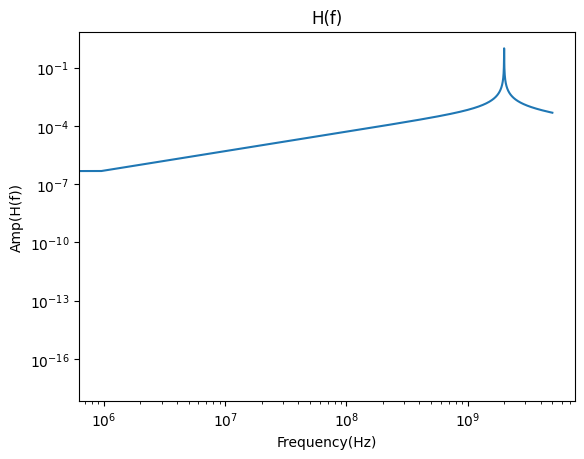

In [17]:
# Filter's looing
Cutoff = 1

tf_plot = tf[:len(tf)//2 // Cutoff]
H_f_plot = H_f[:len(H_f)//2 // Cutoff]
plt.figure()
plt.plot(tf_plot,H_f_plot)
plt.xlabel('Frequency(Hz)')
plt.ylabel('Amp(H(f))')
plt.title('H(f)')
plt.xscale('log')
plt.yscale('log')
plt.show()

In [18]:
# Noise Type : With Filtering
f_U_noise = X / ( 1 + 1j * QualityFactor * (freqs / fres - fres / freqs))



U_noise = np.fft.ifft(f_U_noise)
JNNoise_Ex = np.real(U_noise)

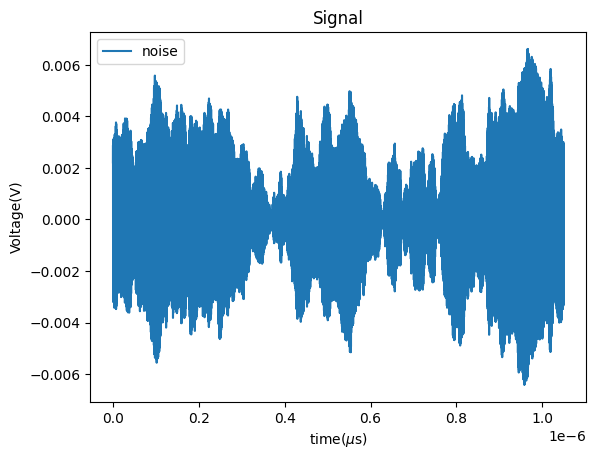

In [19]:
plt.figure()
#plt.plot(t * 1e6, signal, label = 'raw signal')
plt.plot(t, JNNoise_Ex, label = 'noise')
plt.legend()
plt.xlabel('time($\mu$s)')
plt.ylabel('Voltage(V)')
plt.title('Signal')
plt.show()

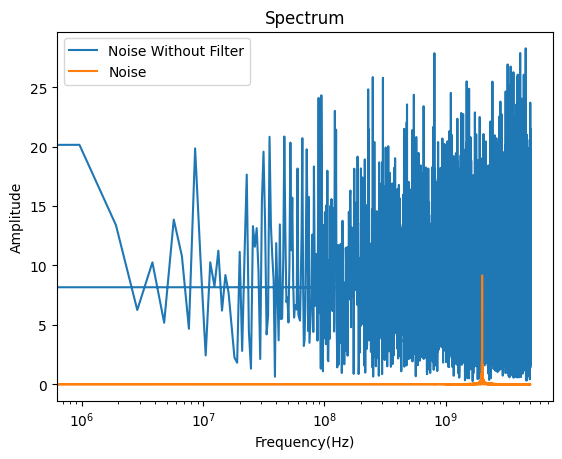

In [20]:
# Cutoff is for throw out the high frequency part
Cutoff = 8
tf_plot = tf[:len(tf) // 2 // Cutoff]

plt.figure()
plt.plot(tf, abs(X), label = 'Noise Without Filter')
plt.plot(tf, abs(f_U_noise), label = 'Noise')
plt.xscale('log')
plt.xlabel('Frequency(Hz)')
plt.ylabel('Amplitude')
plt.title('Spectrum')
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


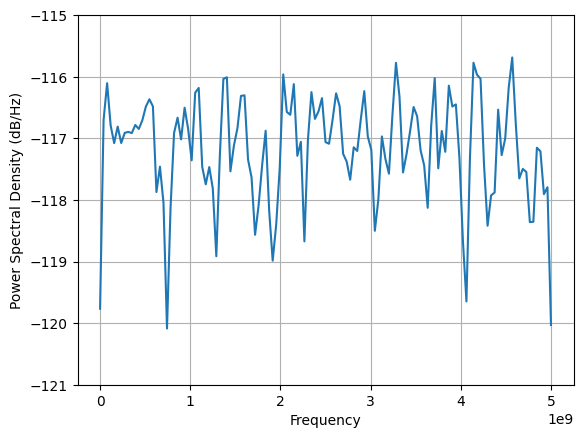

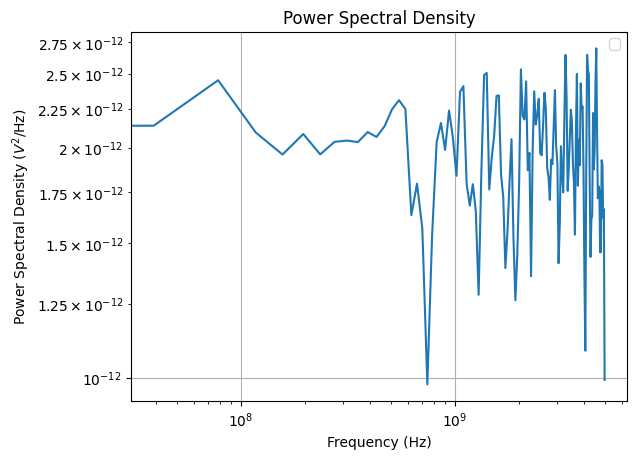

In [21]:
P_raw, f_raw = plt.psd(signal, Fs = samplerate)

f = f_raw
P = P_raw
plt.figure()
plt.plot(f, P)
#plt.plot(f, abs(X * X))
plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.xscale('log')
plt.ylabel(r'Power Spectral Density ($V^2$/Hz)')
#plt.axhline(4*kB*temp_res*R, label=r'$4k_BTR$', color='orange')
#plt.plot(4*kB*temp_res*ReZ(f))
plt.title('Power Spectral Density')
plt.legend()
plt.grid()
plt.show()

Test recording:

- Scale the *TotalTime*

    - don't affect the psd height and the total bandwidth

    - it only affect the accuracy of the spectrum

- Scale the *dt*

    - if *dt* increase, psd increase, bandwidth decrease ( total power is still the same)

- Scale the *U_rms*

    - if *U_rms* increase, psd increase, bandwidth is still the same
    

In [22]:
initialization()
'''
TotalTimeList = np.linspace(TotalTime / 10, TotalTime * 10, 10)
for TotalTime in TotalTimeList:
    samples = TotalTime * 1.05 / dt
    # 1.05 is used to make  sure 
    samplerate = 1 / dt
    t = np.linspace(0, samples / samplerate, int(samples))
    bandwidth = U_rms

    # generate a white noise signal
    signal = np.random.normal(0, bandwidth, size = len(t))
    P_raw, f_raw = plt.psd(signal, Fs = samplerate)

    f = f_raw
    P = P_raw
    plt.figure()
    plt.plot(f, P, label = 'TotalTime = {:.2f}'.format(TotalTime))
    plt.yscale('log')
    plt.xlabel('Frequency (Hz)')
    plt.xscale('log')
    plt.ylabel(r'Power Spectral Density ($V^2$/Hz)')
    #plt.axhline(4*kB*temp_res*R, label=r'$4k_BTR$', color='orange')
    #plt.plot(4*kB*temp_res*ReZ(f))
    plt.title('Power Spectral Density - TotalTime Scaling')
    plt.legend()
    plt.grid()
    plt.show()
'''
initialization()
'''
dtList = np.linspace(dt / 10, dt * 10, 10)
for dt in dtList:
    samples = TotalTime * 1.05 / dt
    # 1.05 is used to make  sure 
    samplerate = 1 / dt
    t = np.linspace(0, samples / samplerate, int(samples))
    bandwidth = U_rms

    # generate a white noise signal
    signal = np.random.normal(0, bandwidth, size = len(t))
    P_raw, f_raw = plt.psd(signal, Fs = samplerate)

    f = f_raw
    P = P_raw
    plt.figure()
    plt.plot(f, P, label = 'TotalTime = {:.2f}'.format(TotalTime))
    plt.yscale('log')
    plt.xlabel('Frequency (Hz)')
    plt.xscale('log')
    plt.ylabel(r'Power Spectral Density ($V^2$/Hz)')
    #plt.axhline(4*kB*temp_res*R, label=r'$4k_BTR$', color='orange')
    #plt.plot(4*kB*temp_res*ReZ(f))
    plt.title('Power Spectral Density - TotalTime Scaling')
    plt.legend()
    plt.grid()
    plt.show()
'''
initialization()
'''
U_rmsList = np.linspace(U_rms / 10, U_rms * 10, 10)
for U_rms in U_rmsList:
    samples = TotalTime * 1.05 / dt
    # 1.05 is used to make  sure 
    samplerate = 1 / dt
    t = np.linspace(0, samples / samplerate, int(samples))
    bandwidth = U_rms

    # generate a white noise signal
    signal = np.random.normal(0, bandwidth, size = len(t))
    P_raw, f_raw = plt.psd(signal, Fs = samplerate)

    f = f_raw
    P = P_raw
    plt.figure()
    plt.plot(f, P, label = 'TotalTime = {:.2f}'.format(TotalTime))
    plt.yscale('log')
    plt.xlabel('Frequency (Hz)')
    plt.xscale('log')
    plt.ylabel(r'Power Spectral Density ($V^2$/Hz)')
    #plt.axhline(4*kB*temp_res*R, label=r'$4k_BTR$', color='orange')
    #plt.plot(4*kB*temp_res*ReZ(f))
    plt.title('Power Spectral Density - TotalTime Scaling')
    plt.legend()
    plt.grid()
    plt.show()
'''
initialization()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


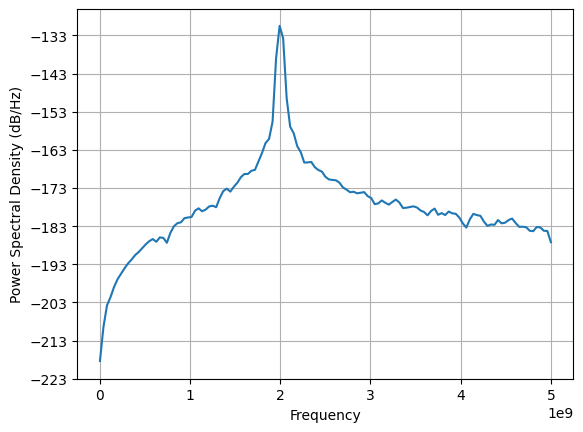

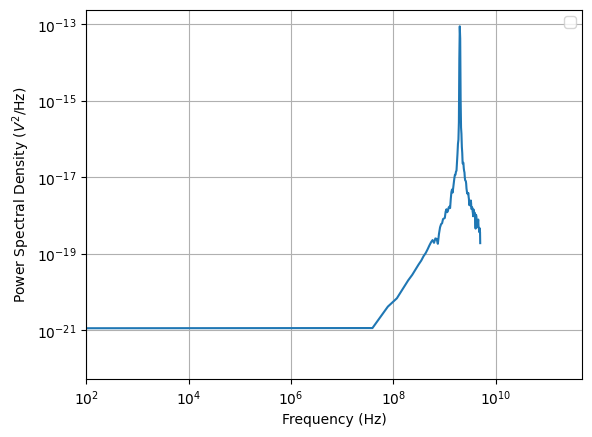

In [23]:
P_filtered, f_filtered = plt.psd(JNNoise_Ex, Fs = samplerate)
#P_filtered, f_filtered = plt.psd(U_noise, Fs = samplerate)
f = f_filtered
P = P_filtered

plt.figure()
plt.plot(f, P)
plt.xscale('log')
plt.xlim((1e2, 5e11))
plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel(r'Power Spectral Density ($V^2$/Hz)')
#plt.axhline(4*kB*temp_res*R, label=r'$4k_BTR$', color='orange')
#plt.plot(4*kB*temp_res*ReZ(f))
plt.legend()
plt.grid()
plt.show()

In [24]:
def White_Noise_Generation(TotalTime, dt, U_rms):
    samples = TotalTime * 1.05 / dt
    # 1.5 is used to make  sure 
    samplerate = 1 / dt
    t = np.linspace(0, samples / samplerate, int(samples))
    bandwidth = U_rms

    # generate a white noise signal
    signal = np.random.normal(0, bandwidth, size = len(t))
    return signal


def Filtered_Noise_Generation(TotalTime, dt, U_rms, fres, QualityFactor):
    samples = TotalTime * 1.05 / dt
    # 1.5 is used to make  sure 
    samplerate = 1 / dt
    t = np.linspace(0, samples / samplerate, int(samples))
    bandwidth = U_rms

    # generate a white noise signal
    signal = np.random.normal(0, bandwidth, size = len(t))
    X = np.fft.fft(signal)
    tf = np.fft.fftfreq(len(signal), dt)
    N = len(X)

    freqs = np.fft.fftfreq(N) * samplerate
    freqs[0] = 1e-5
    f_U_noise = X / ( 1 + 1j * QualityFactor * (freqs / fres - fres / freqs))

    U_noise = np.fft.ifft(f_U_noise)
    signal = np.real(U_noise)
    return signal


In the next 4 parts, we will use RK45 to simulate the particles in 4 conditions:
- a single particle driven by White Noise/Filtered Noise
- a single particle driven by White Noise/Filtered Noise + A Damping Force
- a spring driven by White Noise + Damping Force
- a spring with micromotion driven by White Noise + Damping Force

After the simulation, 3 energy fitting method are applied to get the final temperature

- average kinetic energy
- 2 * kinetic energy (according to Virial Theorem) averaged over a period
- total energy averaged over a period


In [139]:
kB = 1.380649e-23
q = 1.60217663e-19


# Energy calculation
def Potential_Energy(t, x):
    return 0.5 * k * x ** 2

# Method: average kinetic energy
def Ave_E_kin(t_list, x_list, vx_list):
    # change the energy unit to Kelvin
    E_kin = np.array([a ** 2 * 0.5 * m / kB for a in vx_list])
    E_kin_average = np.average(E_kin)
    return E_kin_average

# Method: E_kin fitting
def E_kin_fitting(t_list, x_list, vx_list, Plot = True):
    E_kin = [a ** 2  * 0.5 * m / kB for a in vx_list]
    # turn the unit to be the kinetic energy (T)

    #E_kin_fitfunc  = lambda p, x: p[0]/np.sqrt(x-p[1])*np.exp(- (x-p[1])/p[2])
    E_kin_fitfunc  = lambda p, x: p[0]/np.sqrt(x)*np.exp(- (x)/p[1])
    E_kin_errfunc  = lambda p, x, y: (y - E_kin_fitfunc(p, x))
       
    plt.clf()
    E_kin_n, E_kin_edges= np.histogram(E_kin, 2000, density=True)
    #plt.title('Histogram for velocity')
    #plt.show()
    xdata = 0.5*(E_kin_edges[1:] + E_kin_edges[:-1])
    ydata = E_kin_n
 

    #init  = [vx_list[0] ** 2  * 0.5 * m, 0.,  1000, 0. ]
    #init = [0.2752632719693038, 0., 50 * kB / q * 1000,]
    #init = [0.2752632719693038, 50 * kB / q * 1000]
    init = [10, 10]
    
    out   = leastsq(E_kin_errfunc, init, args=(xdata, ydata))
    c     = out[0]

    #print("A exp[- (x-mu)/sigma)] + k ")
    #print("Fit Coefficients:")
    #print(c[0],c[1],c[2])
    if Plot:
        plt.plot(xdata, E_kin_fitfunc(c, xdata), label = 'Fitting Curve')
        plt.plot(xdata, ydata, label = 'raw data')
        plt.legend()
        plt.xlabel('Kinetic Energy/meV')
        plt.ylabel('Probability')
        #plt.title(r'$A = %.3f\  \mu = %.3f\  \sigma = %.3f$' %(c[0],c[1],c[2]))
        plt.title(r'$A = %.3f\ \sigma = %.3f$' %(c[0],c[1]))
        #return c[2] / kB * q / 1000
    
    return c[1]

# Method: 2 E_kin fitting(By Virial Theorem)
def E_kin2_fitting(t_list, x_list, vx_list, Plot = True):
    E_kin = [2 * a ** 2  * 0.5 * m / kB for a in vx_list]
    # turn the unit to be the kinetic energy (T)

    #E_kin_fitfunc  = lambda p, x: p[0]/np.sqrt(x-p[1])*np.exp(- (x-p[1])/p[2])
    E_kin_fitfunc  = lambda p, x: p[0]/np.sqrt(x)*np.exp(- (x)/p[1])
    E_kin_errfunc  = lambda p, x, y: (y - E_kin_fitfunc(p, x))
       
    plt.clf()
    E_kin_n, E_kin_edges= np.histogram(E_kin, 2000, density=True)
    #plt.title('Histogram for velocity')
    #plt.show()
    xdata = 0.5*(E_kin_edges[1:] + E_kin_edges[:-1])
    ydata = E_kin_n
 

    #init  = [vx_list[0] ** 2  * 0.5 * m, 0.,  1000, 0. ]
    #init = [0.2752632719693038, 0., 50 * kB / q * 1000,]
    #init = [0.2752632719693038, 50 * kB / q * 1000]
    init = [10, 100]
    
    out   = leastsq(E_kin_errfunc, init, args=(xdata, ydata))
    c     = out[0]

    #print("A exp[- (x-mu)/sigma)] + k ")
    #print("Fit Coefficients:")
    #print(c[0],c[1],c[2])
    if Plot:
        plt.plot(xdata, E_kin_fitfunc(c, xdata), label = 'Fitting Curve')
        plt.plot(xdata, ydata, label = 'raw data')
        plt.legend()
        plt.xlabel('Kinetic Energy/K')
        plt.ylabel('Probability')
        #plt.title(r'$A = %.3f\  \mu = %.3f\  \sigma = %.3f$' %(c[0],c[1],c[2]))
        plt.title(r'$A = %.3f\ \sigma = %.3f$' %(c[0],c[1]))
        #return c[2] / kB * q / 1000
    
    return c[1]

# Method 3: E_tot fitting
def E_tot_fitting(t_list, x_list, vx_list, Plot = True):
    E_tot = [(Potential_Energy(t, x) + v ** 2  * 0.5 * m)/kB for t, x, v in zip(t_list, x_list, vx_list)]
    # turn the unit to be the kinetic energy (K)

    E_tot_fitfunc  = lambda p, x: p[0]/np.sqrt(x)*np.exp(- (x)/p[1]) 
    E_tot_errfunc  = lambda p, x, y: (y - E_tot_fitfunc(p, x))
       
    plt.clf()
    E_tot_n, E_tot_edges= np.histogram(E_tot, 2000, density=True)
    #plt.title('Histogram for velocity')
    #plt.show()
    xdata = 0.5*(E_tot_edges[1:] + E_tot_edges[:-1])
    ydata = E_tot_n
 

    #init  = [vx_list[0] ** 2  * 0.5 * m, 0.,  1000, 0. ]
    #init = [0.2752632719693038, 0., 50 * kB / q * 1000,]
    #init = [0.2752632719693038, 50 * kB / q * 1000]
    init = [10, 1000]
    
    out   = leastsq(E_tot_errfunc, init, args=(xdata, ydata))
    c     = out[0]

    #print("A exp[- (x-mu)/sigma)] + k ")
    #print("Fit Coefficients:")
    #print(c[0],c[1],c[2])
    if Plot:
        plt.plot(xdata, E_tot_fitfunc(c, xdata), label = 'Fitting Curve')
        plt.plot(xdata, ydata, label = 'raw data')
        plt.legend()
        plt.xlabel('Total Energy/K')
        plt.ylabel('Probability')
        #plt.title(r'$A = %.3f\  \mu = %.3f\  \sigma = %.3f$' %(c[0],c[1],c[2]))
        plt.title(r'$A = %.3f\ \sigma = %.3f$' %(c[0],c[1]))
        #return c[2] / kB * q / 1000
    
    return c[1]

# Part 1: A single Particle driven by White Noise

In [26]:
initialization()

Differential equation

In [27]:
def DevMotion_Noise(t, Vec, WithNoise):
    x,  v = Vec
    #a = - k * x / m
    a = 0
    if WithNoise:
        posi = int(t/dt)
        if (posi + 1) > len(JNNoise_Ex) -1:
            a = a + JNNoise_Ex[:-1]
        else:
            a = a + JNNoise_Ex[posi] + (JNNoise_Ex[posi + 1] - JNNoise_Ex[posi]) * (t / dt - posi)
        return v, a
    else: 
        return v, a

In [257]:
#initialization()
initializaiton(type = 'Filtered')
N = int(np.round(TotalTime / dt))

t_eval = np.linspace(0, TotalTime, N + 1)
#print(len(t_eval))
#print(len(JNNoise_Ex))
JNNoise_Ex = White_Noise_Generation(TotalTime, dt, U_rms, )
#JNNoise_Ex = Filtered_Noise_Generation(TotalTime, dt, U_rms, fres, QualityFactor)
solution = solve_ivp(fun=lambda t, Vec: DevMotion_Noise(t,
                                                        Vec,
                                                        WithNoise = True), 
                                    t_span = (0, TotalTime), 
                                    y0 = Vec0, 
                                    t_eval = t_eval, 
                                    first_step = dt,
                                    max_step = dt,
                                    atol = 1e-1,
                                    rtol = 1e-1,
                                    method = 'RK45',
                                    )

t_eval = solution.t
Vec_eval = solution.y
x_eval = Vec_eval[0, :]
vx_eval = Vec_eval[1, :]

NameError: name 'initializaiton' is not defined

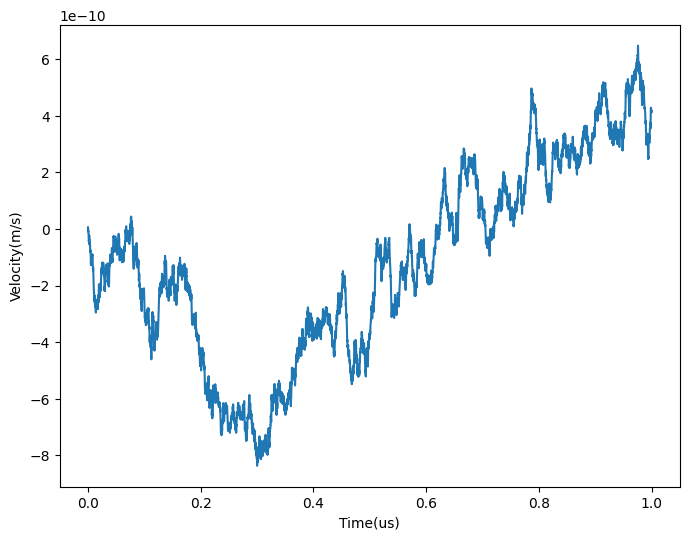

In [258]:
plt.figure(figsize=(8,6))
plt.plot(t_eval * 1e6, vx_eval)
plt.xlabel('Time(us)')
plt.ylabel('Velocity(m/s)')
plt.show()

By average kinetic energy, the final Temperature is 48.82
By kinetic energy fitting, the final Temperature is 153.99


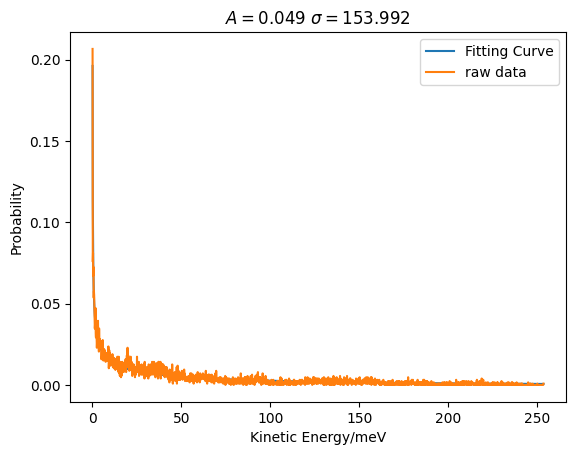

In [259]:
print('By average kinetic energy, the final Temperature is {:.2f}'.format(Ave_E_kin(t_eval, x_eval, vx_eval)))
print('By kinetic energy fitting, the final Temperature is {:.2f}'.format(E_kin_fitting(t_eval, x_eval, vx_eval, Plot = True)))

#### Central Limit Theorem test 

- 30 interation

In [31]:
import tqdm

In [261]:
#initialization()
initialization(type = 'Filtered')
N = int(np.round(TotalTime / dt))

t_eval = np.linspace(0, TotalTime, N + 1)
#print(len(t_eval))
#print(len(JNNoise_Ex))
Ave_E_kin_list_Noise = []
E_kin_fitting_list_Noise = []
for i in tqdm.trange(100):
    JNNoise_Ex = White_Noise_Generation(TotalTime, dt, U_rms)
    #JNNoise_Ex = Filtered_Noise_Generation(TotalTime, dt, U_rms, fres, QualityFactor)
    solution = solve_ivp(fun=lambda t, Vec: DevMotion_Noise(t,
                                                            Vec,
                                                            WithNoise = True), 
                                        t_span = (0, TotalTime), 
                                        y0 = Vec0, 
                                        t_eval = t_eval, 
                                        first_step = dt,
                                        max_step = dt,
                                        atol = 1e-1,
                                        rtol = 1e-1,
                                        method = 'RK45',
                                        )

    t_eval = solution.t
    Vec_eval = solution.y
    x_eval = Vec_eval[0, :]
    vx_eval = Vec_eval[1, :]
    Ave_E_kin_list_Noise.append(Ave_E_kin(t_eval, x_eval, vx_eval))
    E_kin_fitting_list_Noise.append(E_kin_fitting(t_eval, x_eval, vx_eval, Plot = False))
    #print('By average knetic energy, the final Temperature is {:.2f}'.format(Ave_E_kin(t_eval, x_eval, vx_eval)))
    #print('By kinetic energy fitting, the final temperature is {:.2f}'.format(E_kin_fitting(t_eval, x_eval, vx_eval, Plot = False)))



 64%|██████▍   | 64/100 [00:33<00:19,  1.88it/s]C:\Users\electron\AppData\Local\Temp\ipykernel_24396\278524471.py:22: RuntimeWarning: overflow encountered in exp
  E_kin_fitfunc  = lambda p, x: p[0]/np.sqrt(x)*np.exp(- (x)/p[1])
100%|██████████| 100/100 [01:01<00:00,  1.64it/s]


<Figure size 640x480 with 0 Axes>

In [262]:
print(Ave_E_kin_list_Noise)
print(E_kin_fitting_list_Noise)

[16.369948504701128, 512.8739137127874, 35.39529491789338, 27.190388353303263, 106.04088475070235, 101.8466246266956, 87.5849820737942, 18.921537637258986, 86.60649469693371, 70.75629830168765, 111.65866368741071, 175.5041993507433, 131.10783131328668, 15.83390716948885, 28.26703345126756, 49.07570655479504, 133.87763135245177, 27.753280942977003, 54.65622030824963, 224.52257418793218, 124.51317718882466, 30.56027346230366, 97.53000265137184, 38.59396908636929, 116.56450173403506, 39.94920334415583, 17.906747197433557, 204.0056070574781, 24.952795687573662, 179.4749734955416, 107.58742979303722, 30.271134248973606, 352.96201734228094, 393.624601910669, 200.8100843926351, 9.167007176797242, 223.5577662658301, 172.56381308252676, 70.62773437286198, 21.685279982080797, 935.5338486618938, 252.35901381564594, 187.85882266012467, 84.29457163971762, 787.3195712437341, 246.1303615193387, 302.2843563161704, 71.99149633974292, 76.95984327213888, 161.66097726043836, 213.97295134456098, 461.092541

In [266]:

print(len(Ave_E_kin_list_Noise))
print(len(E_kin_fitting_list_Noise))
for i in range(len(Ave_E_kin_list_Noise)):
    if E_kin_fitting_list_Noise[i] > Ave_E_kin_list_Noise[i] * 5:
        del Ave_E_kin_list_Noise[i]
        del E_kin_fitting_list_Noise[i]
    if E_kin_fitting_list_Noise[i] < 0:
        del Ave_E_kin_list_Noise[i]
        del E_kin_fitting_list_Noise[i]



76
76


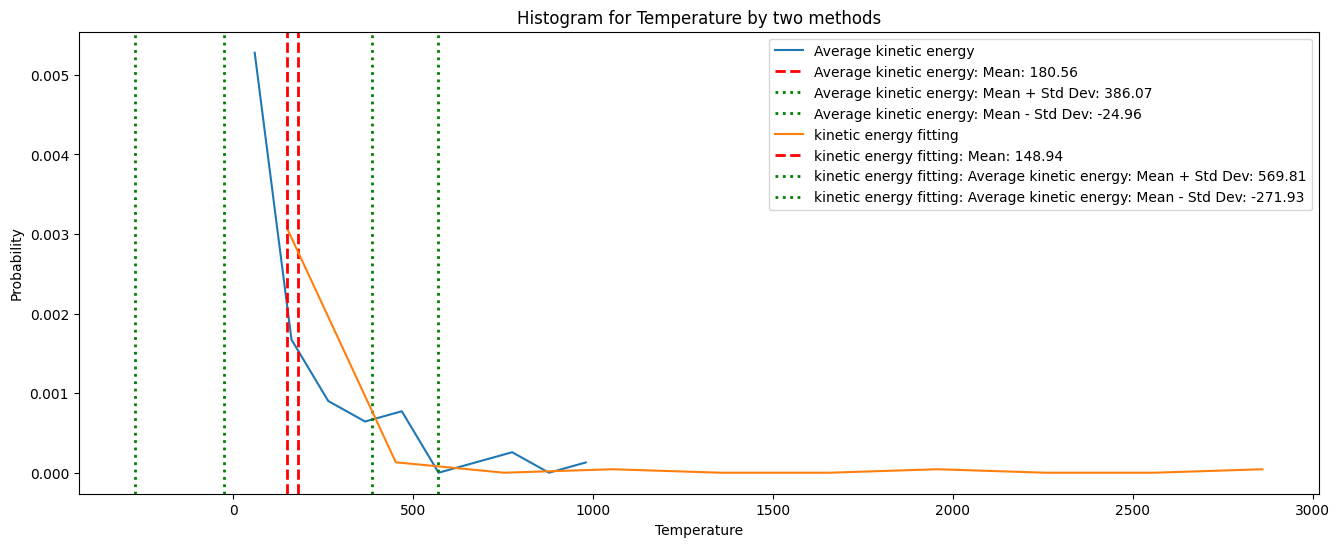

In [267]:
plt.figure(figsize=(16,6))
Ave_E_kin_n_Noise, Ave_E_kin_edges_Noise= np.histogram(Ave_E_kin_list_Noise, 10, density=True)
mean = np.mean(Ave_E_kin_list_Noise)
std = np.std(Ave_E_kin_list_Noise)
plt.title('Histogram for Temperature by two methods')
#plt.show()
xdata = 0.5*(Ave_E_kin_edges_Noise[1:] + Ave_E_kin_edges_Noise[:-1])
ydata = Ave_E_kin_n_Noise
plt.plot(xdata, ydata, label = 'Average kinetic energy')
plt.axvline(mean, color='red', linestyle='dashed', linewidth=2, label=f'Average kinetic energy: Mean: {mean:.2f}')
plt.axvline(mean + std, color='green', linestyle='dotted', linewidth=2, label=f'Average kinetic energy: Mean + Std Dev: {mean + std:.2f}')
plt.axvline(mean - std, color='green', linestyle='dotted', linewidth=2, label=f'Average kinetic energy: Mean - Std Dev: {mean - std:.2f}')


E_kin_fitting_n_Noise, E_kin_fitting_edges_Noise= np.histogram(E_kin_fitting_list_Noise, 10, density=True)
mean = np.mean(E_kin_fitting_list_Noise)
std = np.std(E_kin_fitting_list_Noise)

xdata = 0.5*(E_kin_fitting_edges_Noise[1:] + E_kin_fitting_edges_Noise[:-1])
ydata = E_kin_fitting_n_Noise
plt.plot(xdata, ydata, label = 'kinetic energy fitting')
plt.axvline(mean, color='red', linestyle='dashed', linewidth=2, label=f'kinetic energy fitting: Mean: {mean:.2f}')
plt.axvline(mean + std, color='green', linestyle='dotted', linewidth=2, label=f'kinetic energy fitting: Average kinetic energy: Mean + Std Dev: {mean + std:.2f}')
plt.axvline(mean - std, color='green', linestyle='dotted', linewidth=2, label=f'kinetic energy fitting: Average kinetic energy: Mean - Std Dev: {mean - std:.2f}')
plt.legend()
plt.xlabel('Temperature')
plt.ylabel('Probability')
plt.show()

White Noise: U_rms = 1e-1

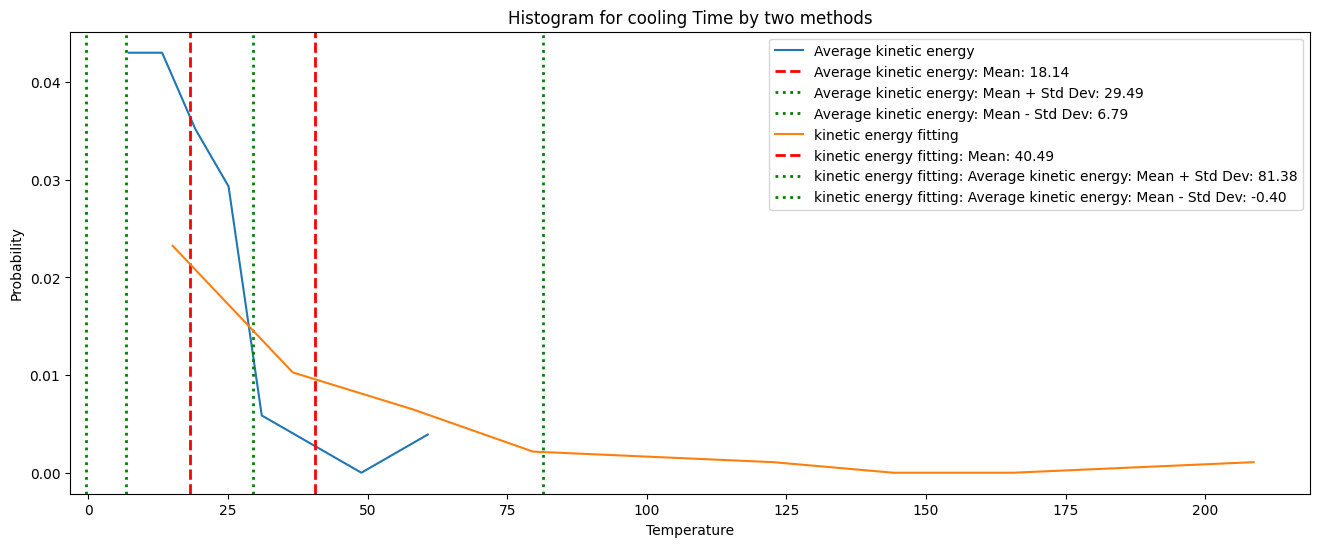

# Part 2: A Single Particle driven by Noise + Damping Force

In [62]:
initialization()

In [63]:
def DevMotion_Noise_Damping(t, Vec, WithNoise):
    x,  v = Vec
    #a = - k * x / m
    a = - beta * v
    if WithNoise:
        posi = int(t/dt)
        if (posi + 1) > len(JNNoise_Ex) -1:
            a = a + JNNoise_Ex[:-1]
        else:
            a = a + JNNoise_Ex[posi] + (JNNoise_Ex[posi + 1] - JNNoise_Ex[posi]) * (t / dt - posi)
        return v, a
    else: 
        return v, a

In [268]:
#initialization()
initialization(type = 'Filtered')
N = int(np.round(TotalTime / dt))

t_eval = np.linspace(0, TotalTime, N + 1)
#print(len(t_eval))
#print(len(JNNoise_Ex))
JNNoise_Ex = White_Noise_Generation(TotalTime, dt, U_rms, )
#JNNoise_Ex = Filtered_Noise_Generation(TotalTime, dt, U_rms, fres, QualityFactor)
solution = solve_ivp(fun=lambda t, Vec: DevMotion_Noise_Damping(t,
                                                        Vec,
                                                        WithNoise = True), 
                                    t_span = (0, TotalTime), 
                                    y0 = Vec0, 
                                    t_eval = t_eval, 
                                    first_step = dt,
                                    max_step = dt,
                                    atol = 1e-1,
                                    rtol = 1e-1,
                                    method = 'RK45',
                                    )

t_eval = solution.t
Vec_eval = solution.y
x_eval = Vec_eval[0, :]
vx_eval = Vec_eval[1, :]

By average knetic energy, the final Temperature is 503.75
By kinetic energy fitting, the final Temperature is 2145.02


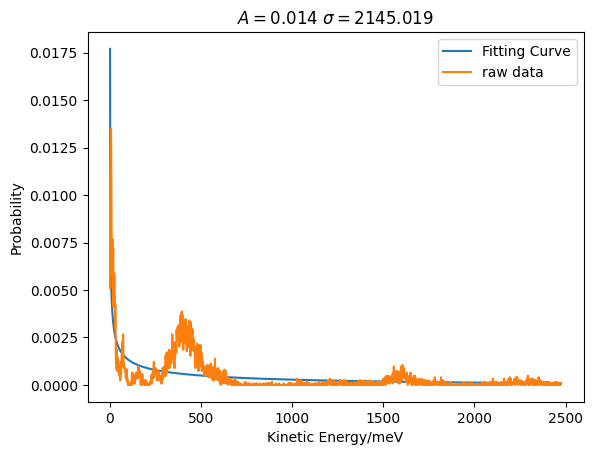

In [269]:
print('By average knetic energy, the final Temperature is {:.2f}'.format(Ave_E_kin(t_eval, x_eval, vx_eval)))
print('By kinetic energy fitting, the final Temperature is {:.2f}'.format(E_kin_fitting(t_eval, x_eval, vx_eval, Plot = True)))

In [271]:
#initialization()
initialization(type = 'Filtered')
N = int(np.round(TotalTime / dt))

t_eval = np.linspace(0, TotalTime, N + 1)
#print(len(t_eval))
#print(len(JNNoise_Ex))
Ave_E_kin_list_Noise_Damping = []
E_kin_fitting_list_Noise_Damping = []
for i in tqdm.trange(100):
    JNNoise_Ex = White_Noise_Generation(TotalTime, dt, U_rms)
    #JNNoise_Ex = Filtered_Noise_Generation(TotalTime, dt, U_rms, fres, QualityFactor)
    solution = solve_ivp(fun=lambda t, Vec: DevMotion_Noise_Damping(t,
                                                            Vec,
                                                            WithNoise = True), 
                                        t_span = (0, TotalTime), 
                                        y0 = Vec0, 
                                        t_eval = t_eval, 
                                        first_step = dt,
                                        max_step = dt,
                                        atol = 1e-1,
                                        rtol = 1e-1,
                                        method = 'RK45',
                                        )

    t_eval = solution.t
    Vec_eval = solution.y
    x_eval = Vec_eval[0, :]
    vx_eval = Vec_eval[1, :]
    Ave_E_kin_list_Noise_Damping.append(Ave_E_kin(t_eval, x_eval, vx_eval))
    E_kin_fitting_list_Noise_Damping.append(E_kin_fitting(t_eval, x_eval, vx_eval, Plot = False))
    #print('By average knetic energy, the final Temperature is {:.2f}'.format(Ave_E_kin(t_eval, x_eval, vx_eval)))
    #print('By kinetic energy fitting, the final temperature is {:.2f}'.format(E_kin_fitting(t_eval, x_eval, vx_eval, Plot = False)))



100%|██████████| 100/100 [00:52<00:00,  1.90it/s]


<Figure size 640x480 with 0 Axes>

In [273]:
print(Ave_E_kin_list_Noise_Damping)
print(E_kin_fitting_list_Noise_Damping)

[13.373127506779207, 75.1878125964762, 175.253507927628, 72.34350670404459, 186.49489294987947, 85.19849198583071, 217.83011525607307, 45.21745976301178, 67.57629536303438, 311.85120558914497, 40.04813056501353, 76.29096973836675, 58.05427185433522, 153.68892700098775, 39.113524740523104, 116.2746321601857, 641.1753901051305, 16.25279623296339, 67.83205080199481, 164.87816238008594, 73.51445998697803, 175.32178049000072, 138.4392588587591, 324.1756873866096, 45.28880799565342, 52.82527608219771, 56.79514105756588, 254.26110736986644, 269.33583732888866, 229.68369811052895, 81.17351865296602, 2317.3271324193747, 27.43169670243148, 49.71665453877793, 145.95929276008414, 107.17607263271866, 164.40992120403277, 377.0140374962964, 16.622654976169, 402.4251270926265, 49.82862870580702, 18.887152991382223, 34.14175479331976, 25.062828671865372, 23.465427233285766, 66.10618230981811, 245.71873681761855, 27.15260280038805, 83.13126680004257, 22.539313000940062, 343.63750671914926, 73.4609199518

In [278]:
print(len(Ave_E_kin_list_Noise_Damping))
print(len(E_kin_fitting_list_Noise_Damping))
for i in range(len(Ave_E_kin_list_Noise_Damping)):
    if E_kin_fitting_list_Noise_Damping[i] > Ave_E_kin_list_Noise_Damping[i] * 5:
        del Ave_E_kin_list_Noise_Damping[i]
        del E_kin_fitting_list_Noise_Damping[i]
    if E_kin_fitting_list_Noise_Damping[i] < 0:
        del Ave_E_kin_list_Noise_Damping[i]
        del E_kin_fitting_list_Noise_Damping[i]

63
63


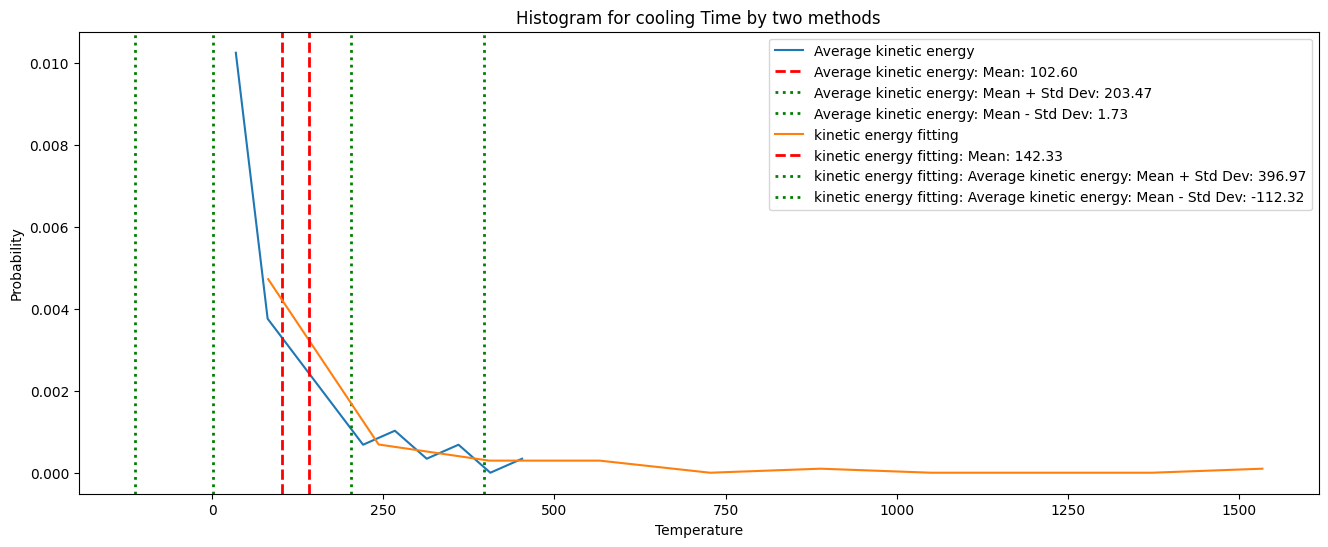

In [279]:
plt.figure(figsize=(16,6))
Ave_E_kin_n_Noise_Damping, Ave_E_kin_edges_Noise_Damping= np.histogram(Ave_E_kin_list_Noise_Damping, 10, density=True)
mean = np.mean(Ave_E_kin_list_Noise_Damping)
std = np.std(Ave_E_kin_list_Noise_Damping)
plt.title('Histogram for cooling Time by two methods')
#plt.show()
xdata = 0.5*(Ave_E_kin_edges_Noise_Damping[1:] + Ave_E_kin_edges_Noise_Damping[:-1])
ydata = Ave_E_kin_n_Noise_Damping
plt.plot(xdata, ydata, label = 'Average kinetic energy')
plt.axvline(mean, color='red', linestyle='dashed', linewidth=2, label=f'Average kinetic energy: Mean: {mean:.2f}')
plt.axvline(mean + std, color='green', linestyle='dotted', linewidth=2, label=f'Average kinetic energy: Mean + Std Dev: {mean + std:.2f}')
plt.axvline(mean - std, color='green', linestyle='dotted', linewidth=2, label=f'Average kinetic energy: Mean - Std Dev: {mean - std:.2f}')


E_kin_fitting_n_Noise_Damping, E_kin_fitting_edges_Noise_Damping= np.histogram(E_kin_fitting_list_Noise_Damping, 10, density=True)
mean = np.mean(E_kin_fitting_list_Noise_Damping)
std = np.std(E_kin_fitting_list_Noise_Damping)

xdata = 0.5*(E_kin_fitting_edges_Noise_Damping[1:] + E_kin_fitting_edges_Noise_Damping[:-1])
ydata = E_kin_fitting_n_Noise_Damping
plt.plot(xdata, ydata, label = 'kinetic energy fitting')
plt.axvline(mean, color='red', linestyle='dashed', linewidth=2, label=f'kinetic energy fitting: Mean: {mean:.2f}')
plt.axvline(mean + std, color='green', linestyle='dotted', linewidth=2, label=f'kinetic energy fitting: Average kinetic energy: Mean + Std Dev: {mean + std:.2f}')
plt.axvline(mean - std, color='green', linestyle='dotted', linewidth=2, label=f'kinetic energy fitting: Average kinetic energy: Mean - Std Dev: {mean - std:.2f}')
plt.legend()
plt.xlabel('Temperature')
plt.ylabel('Probability')
plt.show()

# Part 3: A Spring Under the Noise

In [140]:
initialization()

In [141]:
def DevMotion_Noise_Spring(t, Vec, WithNoise):
    x,  v = Vec
    a = - k * x / m
    #a = - beta * v
    if WithNoise:
        posi = int(t/dt)
        if (posi + 1) > len(JNNoise_Ex) -1:
            a = a + JNNoise_Ex[:-1]
        else:
            a = a + JNNoise_Ex[posi] + (JNNoise_Ex[posi + 1] - JNNoise_Ex[posi]) * (t / dt - posi)
        return v, a
    else: 
        return v, a

In [246]:
#initialization()
initialization(type = 'Filtered')
N = int(np.round(TotalTime / dt))

t_eval = np.linspace(0, TotalTime, N + 1)
#print(len(t_eval))
#print(len(JNNoise_Ex))
JNNoise_Ex = White_Noise_Generation(TotalTime, dt, U_rms, )
#JNNoise_Ex = Filtered_Noise_Generation(TotalTime, dt, U_rms, fres, QualityFactor)
solution = solve_ivp(fun=lambda t, Vec: DevMotion_Noise_Spring(t,
                                                        Vec,
                                                        WithNoise = True), 
                                    t_span = (0, TotalTime), 
                                    y0 = Vec0, 
                                    t_eval = t_eval, 
                                    first_step = dt,
                                    max_step = dt,
                                    atol = 1e-1,
                                    rtol = 1e-1,
                                    method = 'RK45',
                                    )

t_eval = solution.t
Vec_eval = solution.y
x_eval = Vec_eval[0, :]
vx_eval = Vec_eval[1, :]

By average knetic energy, the final Temperature is 199.68
By kinetic energy fitting, the final Temperature is 138.10


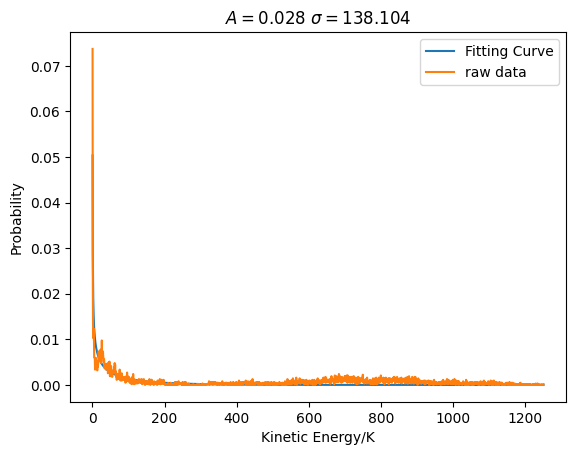

In [247]:
print('By average knetic energy, the final Temperature is {:.2f}'.format(Ave_E_kin(t_eval, x_eval, vx_eval)))
print('By kinetic energy fitting, the final Temperature is {:.2f}'.format(E_kin2_fitting(t_eval, x_eval, vx_eval, Plot = True)))
#print('By total energy fitting, the final Temperature is {:.2f}'.format(E_tot_fitting(t_eval, x_eval, vx_eval, Plot = True)))

In [249]:
#initialization()
initialization(type = 'Filtered')
N = int(np.round(TotalTime / dt))

t_eval = np.linspace(0, TotalTime, N + 1)
#print(len(t_eval))
#print(len(JNNoise_Ex))
Ave_E_kin_list_Spring_Noise = []
E_kin2_fitting_list_Spring_Noise = []
E_tot_fitting_list_Spring_Noise = []
for i in tqdm.trange(100):
    JNNoise_Ex = White_Noise_Generation(TotalTime, dt, U_rms)
    #JNNoise_Ex = Filtered_Noise_Generation(TotalTime, dt, U_rms, fres, QualityFactor)
    solution = solve_ivp(fun=lambda t, Vec: DevMotion_Noise_Spring(t,
                                                            Vec,
                                                            WithNoise = True), 
                                        t_span = (0, TotalTime), 
                                        y0 = Vec0, 
                                        t_eval = t_eval, 
                                        first_step = dt,
                                        max_step = dt,
                                        atol = 1e-1,
                                        rtol = 1e-1,
                                        method = 'RK45',
                                        )

    t_eval = solution.t
    Vec_eval = solution.y
    x_eval = Vec_eval[0, :]
    vx_eval = Vec_eval[1, :]
    Ave_E_kin_list_Spring_Noise.append(Ave_E_kin(t_eval, x_eval, vx_eval))
    E_kin2_fitting_list_Spring_Noise.append(E_kin2_fitting(t_eval, x_eval, vx_eval, Plot = False))
    E_tot_fitting_list_Spring_Noise.append(E_tot_fitting(t_eval, x_eval, vx_eval, Plot = False))
    #print('By average knetic energy, the final Temperature is {:.2f}'.format(Ave_E_kin(t_eval, x_eval, vx_eval)))
    #print('By kinetic energy fitting, the final temperature is {:.2f}'.format(E_kin_fitting(t_eval, x_eval, vx_eval, Plot = False)))



  3%|▎         | 3/100 [00:01<00:52,  1.85it/s]C:\Users\electron\AppData\Local\Temp\ipykernel_24396\278524471.py:62: RuntimeWarning: overflow encountered in exp
  E_kin_fitfunc  = lambda p, x: p[0]/np.sqrt(x)*np.exp(- (x)/p[1])
100%|██████████| 100/100 [01:20<00:00,  1.23it/s]


<Figure size 640x480 with 0 Axes>

In [250]:
print(Ave_E_kin_list_Spring_Noise)
print(E_kin2_fitting_list_Spring_Noise)

[136.02374856379376, 416.68791594327496, 83.40088313714328, 120.241593435135, 110.45629247120942, 148.15501060190638, 794.8088201386543, 135.19227680941353, 19.096995810416907, 774.8861337315317, 52.54301547106895, 490.36482252924645, 401.09048431267667, 180.23737342765722, 32.531799813021145, 91.94828938402166, 86.62269978970335, 23.63555097536898, 75.17490731277819, 51.53582554190058, 103.46872211662756, 166.7765922086272, 644.9815617731895, 461.0103178195017, 52.05418475464318, 16.525564309962846, 182.3705418268653, 24.42281353045406, 232.59589193549465, 565.184523109954, 56.645699175873354, 791.2286671348959, 21.294391325884465, 89.47411517471177, 431.04733968340156, 86.82482535066123, 53.213524807360166, 119.1251037562281, 456.1368140924982, 58.4412532240559, 39.72818120207518, 145.62178942781716, 78.51330031387954, 55.29698591098788, 64.76679067067884, 142.160154029216, 69.73963119908187, 10.806245659414024, 19.4582008314958, 392.5202175706405, 57.59094445983312, 277.274208700358

In [255]:
print(len(Ave_E_kin_list_Spring_Noise))
print(len(E_kin2_fitting_list_Spring_Noise))
for i in range(len(Ave_E_kin_list_Spring_Noise)):
    if E_kin2_fitting_list_Spring_Noise[i] > Ave_E_kin_list_Spring_Noise[i] * 5:
        del Ave_E_kin_list_Spring_Noise[i]
        del E_kin2_fitting_list_Spring_Noise[i]
    if E_kin2_fitting_list_Spring_Noise[i] < 0:
        del Ave_E_kin_list_Spring_Noise[i]
        del E_kin2_fitting_list_Spring_Noise[i]

47
47


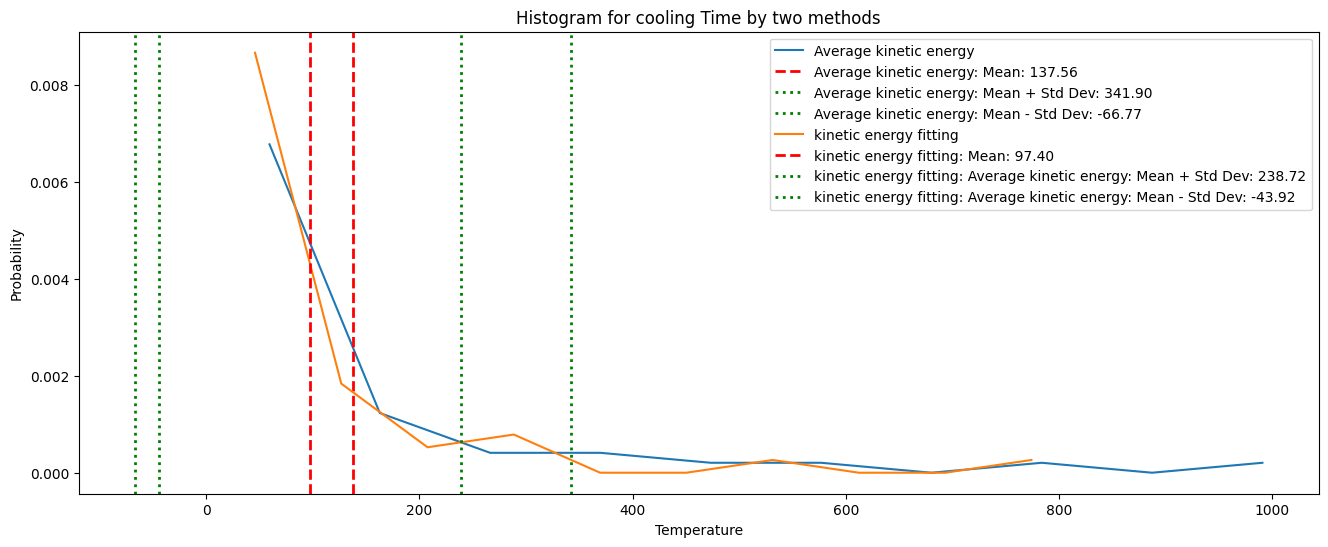

In [256]:
plt.figure(figsize=(16,6))
Ave_E_kin_n_Spring_Noise, Ave_E_kin_edges_Spring_Noise= np.histogram(Ave_E_kin_list_Spring_Noise, 10, density=True)
mean = np.mean(Ave_E_kin_list_Spring_Noise)
std = np.std(Ave_E_kin_list_Spring_Noise)
plt.title('Histogram for cooling Time by two methods')
#plt.show()
xdata = 0.5*(Ave_E_kin_edges_Spring_Noise[1:] + Ave_E_kin_edges_Spring_Noise[:-1])
ydata = Ave_E_kin_n_Spring_Noise
plt.plot(xdata, ydata, label = 'Average kinetic energy')
plt.axvline(mean, color='red', linestyle='dashed', linewidth=2, label=f'Average kinetic energy: Mean: {mean:.2f}')
plt.axvline(mean + std, color='green', linestyle='dotted', linewidth=2, label=f'Average kinetic energy: Mean + Std Dev: {mean + std:.2f}')
plt.axvline(mean - std, color='green', linestyle='dotted', linewidth=2, label=f'Average kinetic energy: Mean - Std Dev: {mean - std:.2f}')


E_kin2_fitting_n_Spring_Noise, E_kin2_fitting_edges_Spring_Noise= np.histogram(E_kin2_fitting_list_Spring_Noise, 10, density=True)
mean = np.mean(E_kin2_fitting_list_Spring_Noise)
std = np.std(E_kin2_fitting_list_Spring_Noise)

xdata = 0.5*(E_kin2_fitting_edges_Spring_Noise[1:] + E_kin2_fitting_edges_Spring_Noise[:-1])
ydata = E_kin2_fitting_n_Spring_Noise
plt.plot(xdata, ydata, label = 'kinetic energy fitting')
plt.axvline(mean, color='red', linestyle='dashed', linewidth=2, label=f'kinetic energy fitting: Mean: {mean:.2f}')
plt.axvline(mean + std, color='green', linestyle='dotted', linewidth=2, label=f'kinetic energy fitting: Average kinetic energy: Mean + Std Dev: {mean + std:.2f}')
plt.axvline(mean - std, color='green', linestyle='dotted', linewidth=2, label=f'kinetic energy fitting: Average kinetic energy: Mean - Std Dev: {mean - std:.2f}')
plt.legend()
plt.xlabel('Temperature')
plt.ylabel('Probability')
plt.show()

# Part 4: A Damping Spring Under the Noise

In [169]:
initialization()

In [170]:
def DevMotion_Noise_Damping_Spring(t, Vec, WithNoise):
    x,  v = Vec
    a = - k * x / m - beta * v
    if WithNoise:
        posi = int(t/dt)
        if (posi + 1) > len(JNNoise_Ex) -1:
            a = a + JNNoise_Ex[:-1]
        else:
            a = a + JNNoise_Ex[posi] + (JNNoise_Ex[posi + 1] - JNNoise_Ex[posi]) * (t / dt - posi)
        return v, a
    else: 
        return v, a

In [219]:
#initialization()
initialization(type = 'Filtered')
N = int(np.round(TotalTime / dt))

t_eval = np.linspace(0, TotalTime, N + 1)
#print(len(t_eval))
#print(len(JNNoise_Ex))
JNNoise_Ex = White_Noise_Generation(TotalTime, dt, U_rms, )
#JNNoise_Ex = Filtered_Noise_Generation(TotalTime, dt, U_rms, fres, QualityFactor)
solution = solve_ivp(fun=lambda t, Vec: DevMotion_Noise_Damping_Spring(t,
                                                        Vec,
                                                        WithNoise = True), 
                                    t_span = (0, TotalTime), 
                                    y0 = Vec0, 
                                    t_eval = t_eval, 
                                    first_step = dt,
                                    max_step = dt,
                                    atol = 1e-1,
                                    rtol = 1e-1,
                                    method = 'RK45',
                                    )

t_eval = solution.t
Vec_eval = solution.y
x_eval = Vec_eval[0, :]
vx_eval = Vec_eval[1, :]

By average knetic energy, the final Temperature is 368.28
By kinetic energy fitting, the final Temperature is 1921.61


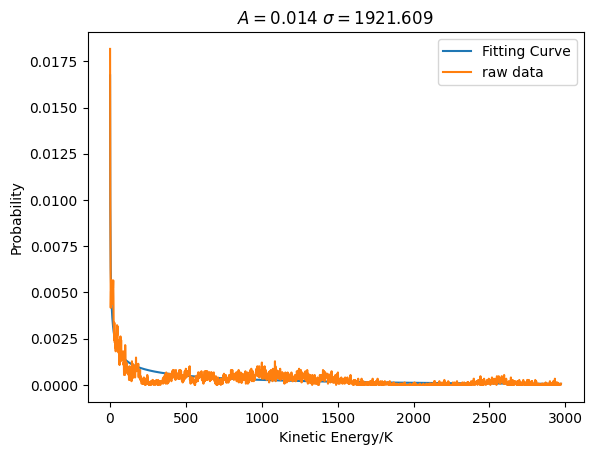

In [220]:
print('By average knetic energy, the final Temperature is {:.2f}'.format(Ave_E_kin(t_eval, x_eval, vx_eval)))
print('By kinetic energy fitting, the final Temperature is {:.2f}'.format(E_kin2_fitting(t_eval, x_eval, vx_eval, Plot = True)))
#print('By total energy fitting, the final Temperature is {:.2f}'.format(E_tot_fitting(t_eval, x_eval, vx_eval, Plot = True)))

In [234]:
initialization()
N = int(np.round(TotalTime / dt))

t_eval = np.linspace(0, TotalTime, N + 1)
#print(len(t_eval))
#print(len(JNNoise_Ex))
Ave_E_kin_list_Noise_Damping_Spring = []
E_kin2_fitting_list_Noise_Damping_Spring = []
E_tot_fitting_list_Noise_Damping_Spring = []
for i in tqdm.trange(500):
    JNNoise_Ex = White_Noise_Generation(TotalTime, dt, U_rms)
    #JNNoise_Ex = Filtered_Noise_Generation(TotalTime, dt, U_rms, fres, QualityFactor)
    solution = solve_ivp(fun=lambda t, Vec: DevMotion_Noise_Damping_Spring(t,
                                                            Vec,
                                                            WithNoise = True), 
                                        t_span = (0, TotalTime), 
                                        y0 = Vec0, 
                                        t_eval = t_eval, 
                                        first_step = dt,
                                        max_step = dt,
                                        atol = 1e-1,
                                        rtol = 1e-1,
                                        method = 'RK45',
                                        )

    t_eval = solution.t
    Vec_eval = solution.y
    x_eval = Vec_eval[0, :]
    vx_eval = Vec_eval[1, :]
    Ave_E_kin_list_Noise_Damping_Spring.append(Ave_E_kin(t_eval, x_eval, vx_eval))
    E_kin2_fitting_list_Noise_Damping_Spring.append(E_kin2_fitting(t_eval, x_eval, vx_eval, Plot = False))
    E_tot_fitting_list_Noise_Damping_Spring.append(E_tot_fitting(t_eval, x_eval, vx_eval, Plot = False))
    #print('By average knetic energy, the final Temperature is {:.2f}'.format(Ave_E_kin(t_eval, x_eval, vx_eval)))
    #print('By kinetic energy fitting, the final temperature is {:.2f}'.format(E_kin_fitting(t_eval, x_eval, vx_eval, Plot = False)))



 21%|██▏       | 107/500 [00:58<03:30,  1.87it/s]c:\Users\electron\miniconda3\envs\e\lib\site-packages\scipy\optimize\_minpack_py.py:492: RuntimeWarning: Number of calls to function has reached maxfev = 600.
  warnings.warn(errors[info][0], RuntimeWarning)
 50%|█████     | 251/500 [02:16<02:14,  1.85it/s]C:\Users\electron\AppData\Local\Temp\ipykernel_24396\278524471.py:62: RuntimeWarning: overflow encountered in exp
  E_kin_fitfunc  = lambda p, x: p[0]/np.sqrt(x)*np.exp(- (x)/p[1])
100%|██████████| 500/500 [04:31<00:00,  1.84it/s]


<Figure size 640x480 with 0 Axes>

In [237]:
print(Ave_E_kin_list_Noise_Damping_Spring)
print(E_kin2_fitting_list_Noise_Damping_Spring)

[199.09132790362412, 110.13351338110836, 295.07567673550307, 35.835132568535336, 362.22108774473764, 338.8221013074355, 104.35093869513094, 19.73928102988925, 141.90395994972448, 25.957955059483858, 587.8038619978678, 423.11447388808995, 117.97673388069514, 47.30612452761723, 124.67549585076104, 129.5720804471768, 53.30705110413836, 441.0881078266468, 60.76194254661373, 31.968088289210232, 140.66271090945762, 298.62221002005913, 245.88907959508498, 63.05990262420208, 390.2261637880547, 97.17304236678488, 382.7293631184788, 1022.1128084876505, 33.48792499577996, 98.80258189192656, 60.136166931848365, 120.41907109029995, 130.93170363234117, 163.2491930990053, 44.35091319752994, 95.46444493226362, 56.97168806308045, 286.3828118246903, 148.79999319797892, 192.73519210054386, 22.051829105080202, 26.436190798500697, 140.0342888740136, 70.30889372929876, 256.9465263938631, 121.83509221143238, 41.775062730221926, 66.43587139668948, 46.14324575906861, 195.42840787525094, 116.03670204593784, 56.

In [244]:
print(len(Ave_E_kin_list_Noise_Damping_Spring))
print(len(E_kin2_fitting_list_Noise_Damping_Spring))
for i in range(len(Ave_E_kin_list_Noise_Damping_Spring)):
    if E_kin2_fitting_list_Noise_Damping_Spring[i] > Ave_E_kin_list_Noise_Damping_Spring[i] * 5:
        del Ave_E_kin_list_Noise_Damping_Spring[i]
        del E_kin2_fitting_list_Noise_Damping_Spring[i]
    if E_kin2_fitting_list_Noise_Damping_Spring[i] < 0:
        del Ave_E_kin_list_Noise_Damping_Spring[i]
        del E_kin2_fitting_list_Noise_Damping_Spring[i]

252
252


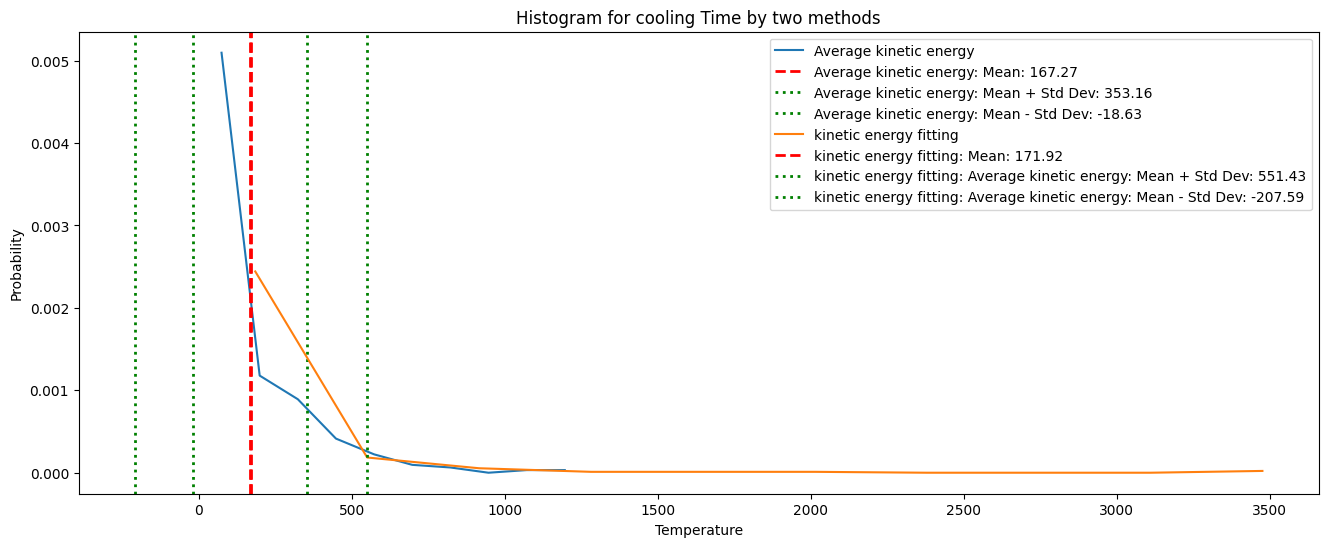

In [245]:
plt.figure(figsize=(16,6))
Ave_E_kin_n_Noise_Damping_Spring, Ave_E_kin_edges_Noise_Damping_Spring= np.histogram(Ave_E_kin_list_Noise_Damping_Spring, 10, density=True)
mean = np.mean(Ave_E_kin_list_Noise_Damping_Spring)
std = np.std(Ave_E_kin_list_Noise_Damping_Spring)
plt.title('Histogram for cooling Time by two methods')
#plt.show()
xdata = 0.5*(Ave_E_kin_edges_Noise_Damping_Spring[1:] + Ave_E_kin_edges_Noise_Damping_Spring[:-1])
ydata = Ave_E_kin_n_Noise_Damping_Spring
plt.plot(xdata, ydata, label = 'Average kinetic energy')
plt.axvline(mean, color='red', linestyle='dashed', linewidth=2, label=f'Average kinetic energy: Mean: {mean:.2f}')
plt.axvline(mean + std, color='green', linestyle='dotted', linewidth=2, label=f'Average kinetic energy: Mean + Std Dev: {mean + std:.2f}')
plt.axvline(mean - std, color='green', linestyle='dotted', linewidth=2, label=f'Average kinetic energy: Mean - Std Dev: {mean - std:.2f}')


E_kin2_fitting_n_Noise_Damping_Spring, E_kin2_fitting_edges_Noise_Damping_Spring= np.histogram(E_kin2_fitting_list_Noise_Damping_Spring, 10, density=True)
mean = np.mean(E_kin2_fitting_list_Noise_Damping_Spring)
std = np.std(E_kin2_fitting_list_Noise_Damping_Spring)

xdata = 0.5*(E_kin2_fitting_edges_Noise_Damping_Spring[1:] + E_kin2_fitting_edges_Noise_Damping_Spring[:-1])
ydata = E_kin2_fitting_n_Noise_Damping_Spring
plt.plot(xdata, ydata, label = 'kinetic energy fitting')
plt.axvline(mean, color='red', linestyle='dashed', linewidth=2, label=f'kinetic energy fitting: Mean: {mean:.2f}')
plt.axvline(mean + std, color='green', linestyle='dotted', linewidth=2, label=f'kinetic energy fitting: Average kinetic energy: Mean + Std Dev: {mean + std:.2f}')
plt.axvline(mean - std, color='green', linestyle='dotted', linewidth=2, label=f'kinetic energy fitting: Average kinetic energy: Mean - Std Dev: {mean - std:.2f}')
plt.legend()
plt.xlabel('Temperature')
plt.ylabel('Probability')
plt.show()